In [60]:
import os
import pandas as pd 
import numpy as np
from natsort import natsorted

from nilearn import datasets, image
from nilearn.maskers import NiftiLabelsMasker

### Part 1: Are there regions of the brain  that are more active when the inner monologue is muted relative to moments where the inner monologue is present? 

Is it possible that when people are presented with internal monologues, the regions of the brain that are typically associated with "mentalizing" or "inferring" the hidden, internal mental states of others, will show less activity, as a result of not _needing_ to do the computation in these moments?

#### Step 1: preparing our parcellation masker
Each of our 28 participants has their original neural image file segmented out into 50 different clips (shifted by 4 seconds to account for the hemodynamic response function (HRF). Each clip corresponds to one of the two movies that they watched (_Physical_, _Stutterer_) and the 12 internal monologue (IM) moments and 13 non-internal monologue (NIM) moments. Importantly, for this analysis, _we're only interested in the IM segments_ - we are looking at how the brain responds when the main character's inner monologue is narrated relative to when those same moments have been silenced. 

To start with this analysis, we load each subject's neural data for all 24 clips, average it across time (e.g., if the clip was 14 seconds, then the neural TR dimension will be 14 before averaging), and then mask the averaged data into 400 Shaefer parcellations. We aggregate each subject's clipwise data into a larger numpy matrix for later use.

In [ ]:
datapath = "/Volumes/Scraplab/fSEND/inarr_data/" #this directory has 28 sub-directories for each subject, eg sub-1/

sublist = [x for x in os.listdir(datapath) if 'sub' in x] #len(sublist) = 28
sublist = natsorted(sublist) #ensure that the list is "naturally" sorted

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
                                                    data_dir=None, base_url=None, resume=True, verbose=1)

masker = NiftiLabelsMasker(
    labels_img=schaefer_atlas.maps,
    strategy='mean',  # Averages across time
    standardize=False  # don't want z-scoring
)

#create an average parcel value matrix for all subjects, for each IM clip
univariate_parcel_matrix = np.empty([28,24,400])

for sx, sub in enumerate(sublist[0:1]):
    #only pull the inner monologue (IM) segments
    sub_clips = [x for x in os.listdir(datapath+sub+'/segmented_files/') if '_IM_' in x] #len = 24, 12 per movie
    sub_clips = natsorted(sub_clips) 

    '''
    It's critical to ensure the sub_clips are naturally sorted, as it will preserve the movie-level and clip-level alignment,
    eg: sub_clips = ['sub-1_physical_clip-1_IM_version-1.nii.gz', ... 'sub-1_stutterer_clip-23_IM_version-1.nii.gz']
    '''

    for cx, clip in enumerate(sub_clips[0:1]):

        clip_segment = image.load_img(datapath+sub+'/segmented_files/'+clip) #shape example: (77, 95, 82, 14)
        clip_avg = image.mean_img(clip_segment) #mean over time (4th dim), shape example: (77, 95, 82)

        roi_data = masker.fit_transform(clip_avg) #shape (1, 400)

        univariate_parcel_matrix[sx, cx, :] = roi_data[0]

# out_path = f"/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/univariate_parcel_matrix"
# np.save(out_path,univariate_parcel_matrix)


<font color='black'>Now that all 28 subjects have their average neural data for each clip segment masked, we re-organize the numpy matrix to a larger dataframe that we will use to run a linear mixed effects model, to test the effects of "silencing" on the parcel values. 

In the next few blocks of code, I simply re-load the numpy matrix, flatten it, and concatenate it back into a fully labeled dataframe which will be fed into R's lmerTest.</font>

In [ ]:
univariate_parcel_matrix = np.load('/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/univariate_parcel_matrix.npy')
univariate_parcel_1d = univariate_parcel_matrix.flatten() #shape (268800,)
df_arr = pd.DataFrame(univariate_parcel_1d)
df_arr.to_csv("/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/parcel_avg_arr.csv", header=False, index=False)

In [ ]:
#create corresponding column and row labels 
datapath = "/Volumes/Scraplab/fSEND/inarr_data/"

sublist = [x for x in os.listdir(datapath) if 'sub' in x] #len(sublist) = 28
sublist = natsorted(sublist)

parcellist,subidlist, movielist, cliplist, versionlist, silencedlist = [], [], [], [], [], []

for sx, sub in enumerate(sublist):

    sub_clips = [x for x in os.listdir(datapath+sub+'/segmented_files/') if '_IM_' in x] #len = 24
    sub_clips = natsorted(sub_clips)

    for cx, clip in enumerate(sub_clips):

        for p in range(400):

            if "silenced" in clip:
                silenced = 1
            else:
                silenced = 0

            parcellist.append(p)
            silencedlist.append(silenced)
            subidlist.append(sub)
            movielist.append(clip.split('_')[1])
            cliplist.append(clip.split('_')[2])
            versionlist.append(clip.split('_')[4].split('.')[0])
#at the end of this, all my lists will be 268800 long

df = pd.DataFrame()
df['avg_column'] = univariate_parcel_1d
df['parcel'] = parcellist
df['sub'] = subidlist
df['movie'] = movielist
df['clip'] = cliplist
df['version'] = versionlist
df['silenced'] = silencedlist

#Resultant dataframe
df.to_csv('/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/univariate_parcel_dataframe.csv', index=False)


In [34]:
df = pd.read_csv('/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/univariate_parcel_dataframe.csv')
df.head()

,avg_column,parcel,sub,movie,clip,version,silenced
0,0.179654,0,sub-1,physical,clip-1,version-1,0
1,0.208834,1,sub-1,physical,clip-1,version-1,0
2,0.012868,2,sub-1,physical,clip-1,version-1,0
3,0.135639,3,sub-1,physical,clip-1,version-1,0
4,0.223891,4,sub-1,physical,clip-1,version-1,0


## <font color='black'>Linear Mixed Effects Model
The below R code models whether the parcel-level signal (avg_column) is predicted by whether or not the clip audio was silenced (~silenced). It also includes the random effect of subject, as well as a random effect of the interaction (denoted by :) between the clip and the movie (i.e., the clips are either from one movie or another). From this code, we get a t-value for each parcel from which we'll calculate our uncorrected (that is, not accounting for the multiple comparisons) p-values.</font>

In [ ]:
'''
library(lmerTest)
library(dplyr)

dataset <- read.csv('/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/univariate_parcel_dataframe.csv')

results_df <- data.frame(t_value = numeric(), stringsAsFactors = FALSE)

for (i in 0:399) {

  filtered_parcel <- filter(dataset, parcel == i)
  
  model <- lmer(avg_column ~ silenced + (1 | sub) + (1 | clip:movie),
   data=filtered_parcel)
  
  coefs <- summary(model)$coefficients

  silenced_row <- coefs["silenced", ]

  new_row <- data.frame(
    t_value = silenced_row["t value"],
    stringsAsFactors = FALSE
  )

  results_df <- rbind(results_df, new_row)
}

write.csv(results_df, "/Users/lindseytepfer/Documents/phd/inarr/analysis/outputs/uncorrected_tvalues.csv", row.names = FALSE)
'''

## <font color='black'> Permutation Test
Next, we also perform a permutation test, randomly assigning the 'silenced' condition within subject, ensuring that these assignments stay consistent across parcels. This is the python implementation, but we ultimately execute this stage of the analysis in R. 
</font>

In [ ]:
#create corresponding column and row labels 
datapath = "/Volumes/Scraplab/fSEND/inarr_data/"

parcel_values = np.loadtxt("/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/parcel_avg_arr.csv", delimiter=',', skiprows=1)

sublist = [x for x in os.listdir(datapath) if 'sub' in x] #len(sublist) = 28
sublist = natsorted(sublist)

parcellist,subidlist, movielist, cliplist, versionlist, silencedlist = [], [], [], [], [], []

for i in range(10000):
    np.random.seed(0)

    for sx, sub in enumerate(sublist):

        flip_version = np.random.choice([0,1])
        print(sub, flip_version)

        sub_clips = [x for x in os.listdir(datapath+sub+'/segmented_files/') if '_IM_' in x] #len = 24
        sub_clips = natsorted(sub_clips)

        for cx, clip in enumerate(sub_clips):

            for p in range(400):

                if flip_version == 1:
                    if "silenced" in clip:
                        silenced = 0
                    else:
                        silenced = 1
                else:
                    if "silenced" in clip:
                        silenced = 1
                    else:
                        silenced = 0
                
                parcellist.append(p)
                silencedlist.append(silenced)
                subidlist.append(sub)
                movielist.append(clip.split('_')[1])
                cliplist.append(clip.split('_')[2])
                versionlist.append(clip.split('_')[4].split('.')[0])

    #at the end of this, all my lists will be 268800 long

    df = pd.DataFrame()
    df['avg_column'] = parcel_values
    df['parcel'] = parcellist
    df['sub'] = subidlist
    df['movie'] = movielist
    df['clip'] = cliplist
    df['version'] = versionlist
    df['silenced'] = silencedlist


In [ ]:
# R VERSION

"""
library(dplyr)
library(naturalsort)
library(lmerTest)
library(foreach)
library(doParallel)

datapath <- "/dartfs/rc/lab/S/Scraplab/fSEND/inarr_data/"
parcel_values <- read.csv("/dartfs/rc/lab/S/Scraplab/lindseytepfer/inarr/univariate_parcels/parcel_avg_arr.csv", header=FALSE)
sublist <- naturalsort(list.files(datapath, pattern="sub"))

# set up parallelization
cores <- detectCores()
cl <- makeCluster(cores -1)
registerDoParallel(cl)

set.seed(0)

t_value_array <- foreach(i=1:5000, .combine='cbind',
                       .packages=c('dplyr','naturalsort','lmerTest'),
                       .options.RNG=0) %dopar% {
  
  start_time <- Sys.time()
  worker_id <- Sys.getpid()
  cat(paste("Iteration", i, "started on worker", worker_id, "\n"), 
    file = "iteration_log.txt", append = TRUE)
  
  # initialize lists
  parcellist <- subidlist <- movielist <- cliplist <- versionlist <- silencedlist <- vector()
  
  for(sub in sublist) {
    flip_version <- sample(0:1,1)
    sub_clips <- naturalsort(list.files(paste0(datapath,sub,"/segmented_files/"), pattern="_IM_"))
    
    for(clip in sub_clips) {
      for(prcl in 0:399) {
        silenced <- ifelse(grepl("silenced",clip), flip_version, 1-flip_version)
        
        parcellist <- c(parcellist, prcl)
        silencedlist <- c(silencedlist, silenced)
        subidlist <- c(subidlist, sub)
        
        parts <- strsplit(clip,"_")[[1]]
        movielist <- c(movielist, parts[2])
        cliplist <- c(cliplist, parts[3])
        versionlist <- c(versionlist, strsplit(parts[5],"\\.")[[1]][1])
      }
    }
  }
  
  df <- data.frame(
    avg_column = parcel_values,
    parcel = parcellist,
    sub = subidlist,
    movie = movielist,
    clip = cliplist,
    version = versionlist,
    silenced = silencedlist
  )
  
  #column names: V1 parcel sub movie clip version silenced
  
  t_values <- sapply(0:399, function(p) {
    model <- lmer(V1 ~ silenced + (1|sub) + (1|clip:movie), data=filter(df, parcel==p))
    summary(model)$coefficients["silenced","t value"]
  })
  
  cat(paste0("[Iter ",i,"] Completed in ",
            round(difftime(Sys.time(),start_time,units="mins"),1)," minutes\n"),
      file="iteration_log.txt", append=TRUE)
  
  t_values
}

stopCluster(cl)

write.csv(t_value_array, "t_values_array.csv", row.names=FALSE)

"""

### <font color='black'> Calculating p-values from permuted t-values, correcting for multiple comparisons
Finally, we take our t-values that were produced from our mixed models, and then generate p-values to inspect how the parcels behave when the internal narratives of the movie clips have been silenced.
</font>

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from nilearn import plotting, datasets, image, surface
import nibabel as nb
from nilearn.plotting import plot_img_on_surf
from nilearn.image import new_img_like

fsaverage = datasets.fetch_surf_fsaverage()

In [69]:
uncorrected_tvals = np.loadtxt('/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/uncorrected_tvalues.csv', delimiter=',', encoding='utf-8-sig', skiprows=1) # shape (400)
permuted_tvals = np.loadtxt("/Volumes/Scraplab/lindseytepfer/inarr/t_values_array.csv", delimiter=',', encoding='utf-8-sig', skiprows=1) # shape (400,5000)
permuted_tvals = np.abs(permuted_tvals)
null_dist = permuted_tvals.max(axis=0) #shape (5000) 

results_pvals = np.empty((400))

for parcel in range(uncorrected_tvals.shape[0]): #400, for each parcel
    results_pvals[parcel] = np.mean(null_dist[:] >= abs(uncorrected_tvals[parcel]))

significant = np.where(results_pvals < 0.05, 1, 0)

In [70]:
#create t-value image
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

#need to insert the 0 for proper indexing. 
schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = uncorrected_tvals[i]

tval_img = nb.Nifti1Image(mapped_data, atlas.affine)
#nb.save(tval_img, 'tvalue_map.nii.gz')


[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [71]:
#Create corrected p-value mask:
n_rois = 399

roi_data = image.get_data(atlas)  # (x,y,z) array with ROI labels
significant_mask = np.zeros_like(roi_data, dtype=np.float32)

for roi_label in range(1, n_rois+1):
    if significant[roi_label-1] == 1:  # ROI labels start at 1
        significant_mask[roi_data == roi_label] = 1  # Tag significant voxels

mask_img = new_img_like(atlas, significant_mask)


[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


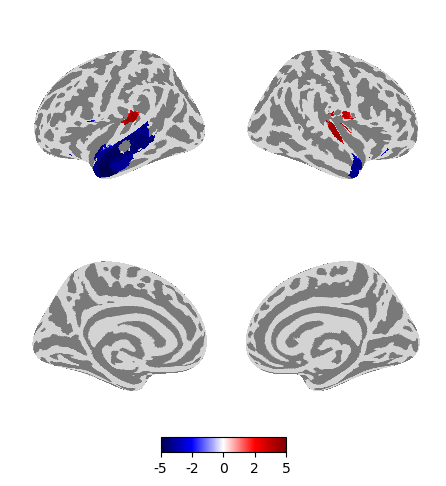

In [73]:
plotting.plot_img_on_surf(tval_img,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    #threshold=0.05,  # we are already masking it with a MASK of significance, 
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    # vmin=0, vmax=.4, #removing these options to let it be automatic
    mask_img=mask_img
)

#fig = plt.gcf()
# fig.savefig('univariate_corrected.png', dpi=300, facecolor='w', bbox_inches='tight')
# plt.close()

plotting.show()